# How to apply Decision Trees and Random Forests to a Regression task

Exploring regressions with Decision Trees and Random Forests.

### 0. Download the dataset from Kaggle

In [137]:
import os
import zipfile
# import pandas as pd

initial_working_directory = os.getcwd()

kaggle_dataset = "new-york-city-taxi-fare-prediction"

kaggle_json_path = '<path_to_kaggle_json>' # replace with path to your kaggle.json file

os.environ['KAGGLE_CONFIG_DIR'] = kaggle_json_path

target_dir = os.path.join('<base_path>', 'Kaggle', kaggle_dataset) # replace <base_path> with desired base directory

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

os.chdir(target_dir)

In [138]:
!kaggle competitions download -c {kaggle_dataset} # take care - the file is huge!

In [139]:
with zipfile.ZipFile(f'{kaggle_dataset}.zip', 'r') as zip_ref:
    zip_ref.extractall()

### 1. Load the libraries/modules

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

### 2. Load the dataset

In [141]:
df = pd.read_csv('train.csv', nrows=100000)

In [142]:
os.chdir(initial_working_directory)

In [ ]:
cwd = os.getcwd()
print(cwd)

### 3. Transform the dataset into a DataFrame

In [144]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


### 4. Exploratory Data Analysis

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  100000 non-null  float64
 6   dropoff_latitude   100000 non-null  float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


In [146]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


In [147]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

Text(0, 0.5, 'Frequency')

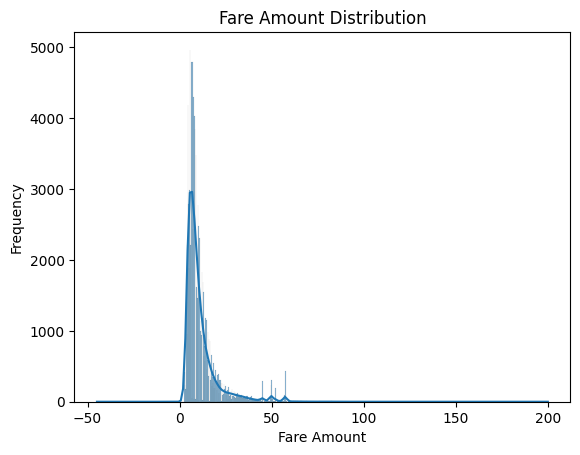

In [148]:
sns.histplot(df['fare_amount'], kde=True)
plt.title('Fare Amount Distribution')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')

In [149]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek + 1

Text(0.5, 1.0, 'Fare Amount by Year')

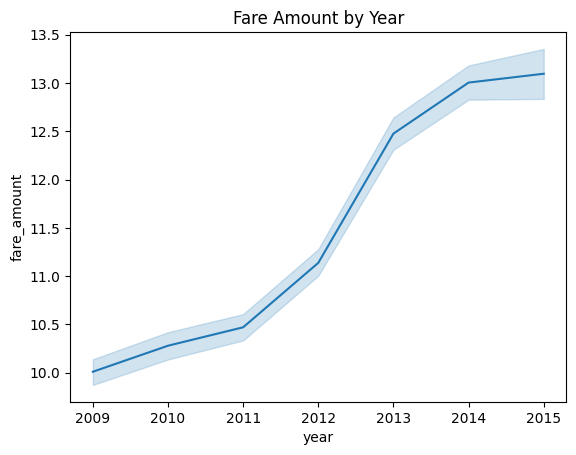

In [150]:
sns.lineplot(x='year', y='fare_amount', data=df)
plt.title('Fare Amount by Year')

Text(0.5, 1.0, 'Fare Amount by Month')

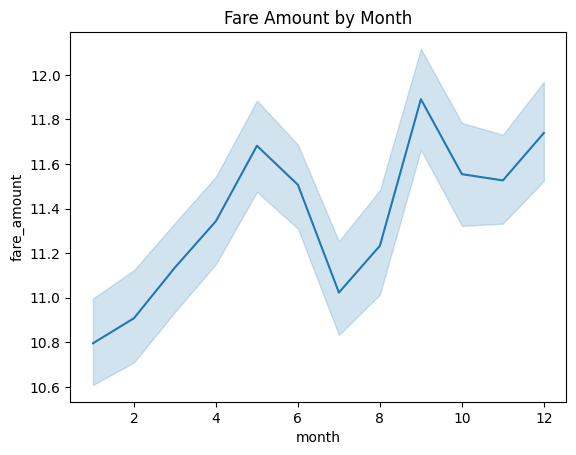

In [151]:
sns.lineplot(x='month', y='fare_amount', data=df)
plt.title('Fare Amount by Month')

Text(0.5, 1.0, 'Fare Amount by Day of Week')

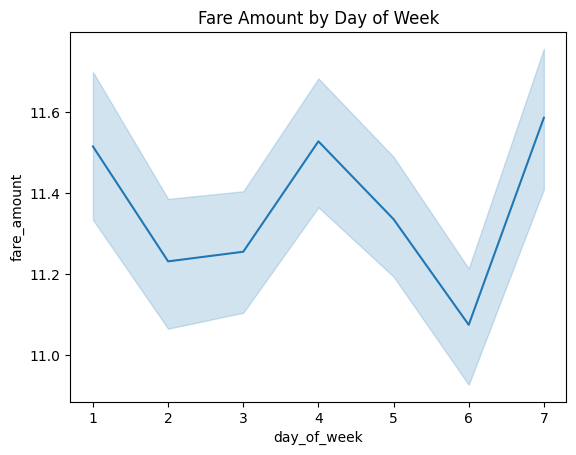

In [152]:
sns.lineplot(x='day_of_week', y='fare_amount', data=df)
plt.title('Fare Amount by Day of Week')

Text(0.5, 1.0, 'Fare Amount by Hour')

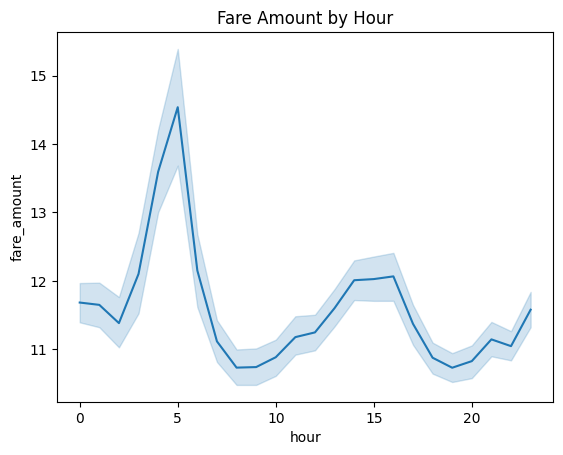

In [153]:
sns.lineplot(x='hour', y='fare_amount', data=df)
plt.title('Fare Amount by Hour')

In [154]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    a = np.sin(delta_lat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(delta_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

df['distance'] = haversine_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

Text(0, 0.5, 'Fare Amount')

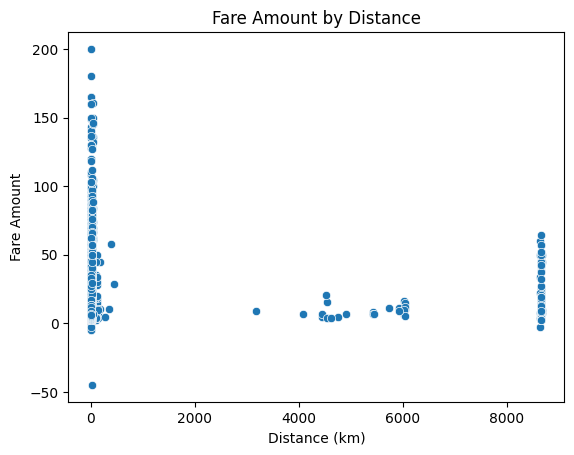

In [155]:
sns.scatterplot(x='distance', y='fare_amount', data=df)
plt.title('Fare Amount by Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Fare Amount')

In [156]:
df[df['distance'] > 2000]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,distance
472,2009-02-22 22:48:00.000000130,2.5,2009-02-22 22:48:00+00:00,0.000000,0.000000,-74.005433,40.726685,2,2009,2,22,22,7,8667.304968
1260,2011-03-10 20:25:00.00000049,5.7,2011-03-10 20:25:00+00:00,-73.973907,40.754743,0.000000,0.000000,2,2011,3,10,20,4,8665.268588
2280,2011-08-29 08:24:00.000000107,8.9,2011-08-29 08:24:00+00:00,-73.936667,40.757815,0.000000,40.757815,1,2011,8,29,8,1,6026.494216
2397,2012-06-24 17:11:10.0000001,45.0,2012-06-24 17:11:10+00:00,0.000000,0.000000,-74.010230,40.714553,2,2012,6,24,17,7,8667.454421
4278,2015-04-07 23:33:02.0000005,7.0,2015-04-07 23:33:02+00:00,-73.972702,40.757423,0.000000,0.000000,1,2015,4,7,23,2,8665.223767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98167,2012-11-25 17:59:00.00000026,4.0,2012-11-25 17:59:00+00:00,0.000000,41.453693,0.000000,0.000000,5,2012,11,25,17,7,4609.440352
98360,2012-07-13 17:01:00.000000107,8.9,2012-07-13 17:01:00+00:00,-1.383332,40.808887,-73.978395,40.779790,1,2012,7,13,17,5,5921.327066
98596,2014-07-20 04:26:00.00000027,19.0,2014-07-20 04:26:00+00:00,0.000000,0.000000,-73.959900,40.801250,1,2014,7,20,4,7,8665.063366
99532,2012-06-25 18:44:00.000000144,8.9,2012-06-25 18:44:00+00:00,-73.978523,69.400000,-73.955138,40.779992,1,2012,6,25,18,1,3182.399985


In [157]:
df = df[df['distance'] < 2000]

In [158]:
df.shape

(99813, 14)

Text(0, 0.5, 'Fare Amount')

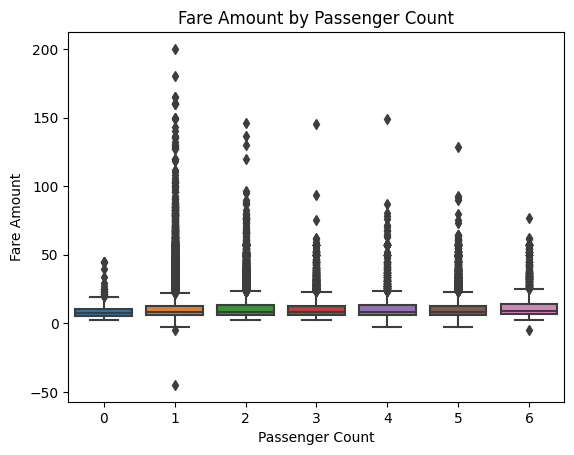

In [159]:
sns.boxplot(x='passenger_count', y='fare_amount', data=df)
plt.title('Fare Amount by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount')

Text(0.05, 0.95, 'R = 0.63, p = 0.00e+00')

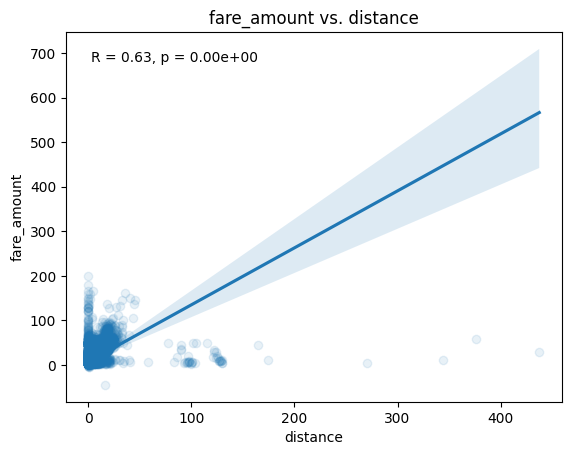

In [160]:
from scipy.stats import pearsonr

x_col = 'distance'
y_col = 'fare_amount'

sns.regplot(x=x_col, y=y_col, data=df, scatter_kws={'alpha': 0.1})
plt.title(f'{y_col} vs. {x_col}')
plt.xlabel(x_col)
plt.ylabel(y_col)

pearson_r, p_value = pearsonr(df[x_col], df[y_col])

plt.text(0.05, 0.95, f"R = {pearson_r:.2f}, p = {p_value:.2e}",
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top')

In [161]:
cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
for col in cols:
    zero_count = (df[col] == 0).sum()
    print(f'Number of zeros in {col}: {zero_count}')

Number of zeros in pickup_longitude: 1833
Number of zeros in pickup_latitude: 1833
Number of zeros in dropoff_longitude: 1833
Number of zeros in dropoff_latitude: 1833


In [162]:
df[(df['pickup_longitude'] > -70) & (df['pickup_longitude'] != 0)].shape

(57, 14)

In [163]:
df[(df['dropoff_longitude'] > -70) & (df['dropoff_longitude'] != 0)].shape

(57, 14)

In [164]:
df[(df['pickup_latitude'] < 40) & (df['pickup_latitude'] != 0)].shape

(72, 14)

In [165]:
df[(df['dropoff_latitude'] < 40) & (df['dropoff_latitude'] != 0)].shape

(68, 14)

In [166]:
def fix_coordinates(df, lon_col, lat_col):
    df.loc[df[lat_col] > 400, lat_col] = df.loc[df[lat_col] > 400, lat_col] / 10
    
    reverse_rows = df[lon_col] > -70
    df.loc[reverse_rows, [lon_col, lat_col]] = df.loc[reverse_rows, [lat_col, lon_col]].values
    
    # reverse_rows = df[lat_col] < 40
    # df.loc[reverse_rows, [lon_col, lat_col]] = df.loc[reverse_rows, [lat_col, lon_col]].values
    
    return df

cols_to_fix = [('pickup_longitude', 'pickup_latitude'), ('dropoff_longitude', 'dropoff_latitude')]

for lon_col, lat_col in cols_to_fix:
    df_fixed = fix_coordinates(df, lon_col, lat_col)

In [167]:
df_fixed[(df_fixed['pickup_longitude'] > -70) & (df_fixed['pickup_longitude'] != 0)].shape

(11, 14)

In [168]:
df_fixed[(df_fixed['pickup_longitude'] > -70) & (df_fixed['pickup_longitude'] != 0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,distance
1181,2012-10-11 00:21:00.000000140,25.0,2012-10-11 00:21:00+00:00,0.033500,-0.004093,0.017980,0.016852,2,2012,10,11,0,4,2.898678
33889,2009-12-05 22:34:00.000000151,6.5,2009-12-05 22:34:00+00:00,-0.051833,-0.032060,-0.048933,-0.034800,2,2009,12,5,22,6,0.443633
50784,2011-08-11 00:35:00.00000077,8.5,2011-08-11 00:35:00+00:00,0.010867,0.115070,0.002200,0.119188,1,2011,8,11,0,4,1.066978
66433,2010-07-28 09:22:00.000000254,7.3,2010-07-28 09:22:00+00:00,-0.003652,0.002802,0.005768,-0.003795,5,2010,7,28,9,3,1.278775
67590,2009-10-30 08:53:00.00000034,15.3,2009-10-30 08:53:00+00:00,0.005913,-0.001745,0.020688,-0.009457,5,2009,10,30,8,5,1.853241
68501,2010-07-11 12:47:00.00000079,6.1,2010-07-11 12:47:00+00:00,0.000775,0.000183,0.006420,0.003535,1,2010,7,11,12,7,0.730018
70511,2009-10-20 11:51:00.0000009,10.1,2009-10-20 11:51:00+00:00,-0.000227,-0.016452,-0.000500,-0.005703,2,2009,10,20,11,2,1.195620
71502,2009-07-01 15:52:00.000000125,6.5,2009-07-01 15:52:00+00:00,0.003682,0.002153,0.002135,0.000165,1,2009,7,1,15,3,0.280100
80442,2010-08-26 14:59:00.0000001,14.1,2010-08-26 14:59:00+00:00,0.001263,-0.001602,-0.001947,-0.004182,5,2010,8,26,14,4,0.457935
89335,2010-05-01 19:24:00.000000179,18.9,2010-05-01 19:24:00+00:00,-0.016618,0.036962,-0.031760,0.032135,5,2010,5,1,19,6,1.767195


In [169]:
df_fixed[(df_fixed['pickup_latitude'] < 40) & (df_fixed['pickup_latitude'] != 0)].shape

(26, 14)

In [170]:
df_fixed[(df_fixed['pickup_latitude'] < 40) & (df_fixed['pickup_latitude'] != 0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,distance
1181,2012-10-11 00:21:00.000000140,25.00,2012-10-11 00:21:00+00:00,0.033500,-0.004093,0.017980,0.016852,2,2012,10,11,0,4,2.898678
8176,2011-04-08 12:58:26.0000005,10.50,2011-04-08 12:58:26+00:00,-73.967350,39.627358,-73.959343,39.625547,1,2011,4,8,12,5,0.714716
8334,2011-02-21 12:16:33.0000003,2.90,2011-02-21 12:16:33+00:00,-73.967160,39.617851,-73.976375,39.605025,1,2011,2,21,12,1,1.630049
8584,2011-05-24 13:46:23.0000003,8.10,2011-05-24 13:46:23+00:00,-73.964460,39.616075,-73.946669,39.604972,1,2011,5,24,13,2,1.961366
10710,2011-02-11 21:46:09.0000001,3.70,2011-02-11 21:46:09+00:00,-73.955411,39.604164,-73.955647,40.772837,1,2011,2,11,21,5,129.950483
11619,2011-05-27 21:47:44.0000002,11.30,2011-05-27 21:47:44+00:00,-73.945106,39.603178,-73.976636,40.749643,1,2011,5,27,21,5,127.509261
29654,2011-02-10 02:22:52.0000001,7.70,2011-02-10 02:22:52+00:00,-73.964531,39.631717,-73.982297,40.775564,1,2011,2,10,2,4,127.198854
30950,2011-04-25 08:57:38.0000005,8.50,2011-04-25 08:57:38+00:00,-73.954724,39.613492,-73.954297,40.767204,1,2011,4,25,8,1,128.286961
33889,2009-12-05 22:34:00.000000151,6.50,2009-12-05 22:34:00+00:00,-0.051833,-0.032060,-0.048933,-0.034800,2,2009,12,5,22,6,0.443633
37038,2011-03-10 16:05:27.0000001,8.10,2011-03-10 16:05:27+00:00,-73.949891,39.620362,-73.954676,40.770738,1,2011,3,10,16,4,127.916599


In [171]:
def replace_near_zeros_with_mean(df, cols, low=-0.1, high=0.1):
    for col in cols:
        mean_value = df[(df[col] < low) | (df[col] > high)][col].mean()
        df.loc[(df[col] >= low) & (df[col] <= high), col] = mean_value

    return df

df_fixed = replace_near_zeros_with_mean(df, ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], -0.2, 0.2)

In [172]:
cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
for col in cols:
    zero_count = (df_fixed[col] == 0).sum()
    print(f'Number of zeros in {col}: {zero_count}')

Number of zeros in pickup_longitude: 0
Number of zeros in pickup_latitude: 0
Number of zeros in dropoff_longitude: 0
Number of zeros in dropoff_latitude: 0


In [173]:
df_fixed[(df_fixed['pickup_longitude'] > -70) & (df_fixed['pickup_longitude'] != 0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,distance


In [174]:
df_fixed[(df_fixed['pickup_latitude'] < 40) & (df_fixed['pickup_latitude'] != 0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,distance
8176,2011-04-08 12:58:26.0000005,10.50,2011-04-08 12:58:26+00:00,-73.967350,39.627358,-73.959343,39.625547,1,2011,4,8,12,5,0.714716
8334,2011-02-21 12:16:33.0000003,2.90,2011-02-21 12:16:33+00:00,-73.967160,39.617851,-73.976375,39.605025,1,2011,2,21,12,1,1.630049
8584,2011-05-24 13:46:23.0000003,8.10,2011-05-24 13:46:23+00:00,-73.964460,39.616075,-73.946669,39.604972,1,2011,5,24,13,2,1.961366
10710,2011-02-11 21:46:09.0000001,3.70,2011-02-11 21:46:09+00:00,-73.955411,39.604164,-73.955647,40.772837,1,2011,2,11,21,5,129.950483
11619,2011-05-27 21:47:44.0000002,11.30,2011-05-27 21:47:44+00:00,-73.945106,39.603178,-73.976636,40.749643,1,2011,5,27,21,5,127.509261
29654,2011-02-10 02:22:52.0000001,7.70,2011-02-10 02:22:52+00:00,-73.964531,39.631717,-73.982297,40.775564,1,2011,2,10,2,4,127.198854
30950,2011-04-25 08:57:38.0000005,8.50,2011-04-25 08:57:38+00:00,-73.954724,39.613492,-73.954297,40.767204,1,2011,4,25,8,1,128.286961
37038,2011-03-10 16:05:27.0000001,8.10,2011-03-10 16:05:27+00:00,-73.949891,39.620362,-73.954676,40.770738,1,2011,3,10,16,4,127.916599
43519,2011-03-24 18:33:44.00000010,14.90,2011-03-24 18:33:44+00:00,-73.958490,39.605743,-73.941292,39.663073,1,2011,3,24,18,4,6.542762
44777,2011-03-28 12:08:51.0000002,7.70,2011-03-28 12:08:51+00:00,-73.978483,39.607752,-73.980734,40.751096,1,2011,3,28,12,1,127.134200


In [176]:
df = df_fixed

In [177]:
df[df['distance'] == 0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,distance
11,2012-12-24 11:24:00.00000098,5.5,2012-12-24 11:24:00+00:00,-73.975189,40.751025,-73.974009,40.751463,3,2012,12,24,11,1,0.0
15,2013-11-23 12:57:00.000000190,5.0,2013-11-23 12:57:00+00:00,-73.975189,40.751025,-73.974009,40.751463,1,2013,11,23,12,6,0.0
26,2011-02-07 20:01:00.000000114,6.5,2011-02-07 20:01:00+00:00,-73.975189,40.751025,-73.974009,40.751463,1,2011,2,7,20,1,0.0
105,2009-03-25 00:08:52.0000001,52.0,2009-03-25 00:08:52+00:00,-74.035839,40.747320,-74.035839,40.747320,1,2009,3,25,0,3,0.0
124,2013-01-17 17:22:00.00000043,8.0,2013-01-17 17:22:00+00:00,-73.975189,40.751025,-73.974009,40.751463,2,2013,1,17,17,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99787,2011-12-21 09:36:00.000000155,13.7,2011-12-21 09:36:00+00:00,-73.937762,40.758157,-73.937762,40.758157,1,2011,12,21,9,3,0.0
99793,2011-11-08 08:54:00.00000079,6.1,2011-11-08 08:54:00+00:00,-73.998613,40.671772,-73.998613,40.671772,5,2011,11,8,8,2,0.0
99829,2012-04-01 17:02:00.0000005,24.9,2012-04-01 17:02:00+00:00,-73.975189,40.751025,-73.974009,40.751463,3,2012,4,1,17,7,0.0
99904,2010-08-14 17:56:04.0000002,6.9,2010-08-14 17:56:04+00:00,-73.975189,40.751025,-73.974009,40.751463,1,2010,8,14,17,6,0.0


In [187]:
df['pickup_latitude'].max()

43.183332

In [178]:
df = df[df['distance'] > 0]

In [179]:
df.shape

(96900, 14)

In [194]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'year', 'month', 'day', 'hour', 'day_of_week',
       'distance'],
      dtype='object')

### 5. Split the data and standardise features

In [195]:
df = df.drop(columns=['key', 'pickup_datetime'])

X = df.drop(columns=['fare_amount'])
y = df['fare_amount']

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [200]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 6. Set model, fit, and get predictions for the decision tree

In [201]:
dt = DecisionTreeRegressor(random_state=101)
dt.fit(X_train_scaled, y_train)

DecisionTreeRegressor(random_state=101)

In [202]:
y_pred_dt = dt.predict(X_test_scaled)

### 7. Evaluate the decision tree model's performance

In [203]:
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print('Decision Tree Regression Performance:')
print('Mean Squared Error:', mse_dt)
print('R-squared:', r2_dt)

Decision Tree Regression Performance:
Mean Squared Error: 34.70543249742002
R-squared: 0.6249704521518453


### 8. Set model, fit, and get predictions for the random forest

In [204]:
rf = RandomForestRegressor(random_state=101)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=101)

In [205]:
y_pred_rf = rf.predict(X_test_scaled)

### 9. Evaluate the random forest model's performance

In [206]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print('Random Forest Regression Performance:')
print('Mean Squared Error:', mse_rf)
print('R-squared:', r2_rf)

Random Forest Regression Performance:
Mean Squared Error: 17.052436565471105
R-squared: 0.8157300712119527


### 10. Compare performances between decision tree and random forest models

In [207]:
print('Decision Tree Regression Performance:')
print('Mean Squared Error:', mse_dt)
print('R-squared:', r2_dt)
print('\n')
print('Random Forest Regression Performance:')
print('Mean Squared Error:', mse_rf)
print('R-squared:', r2_rf)

Decision Tree Regression Performance:
Mean Squared Error: 34.70543249742002
R-squared: 0.6249704521518453


Random Forest Regression Performance:
Mean Squared Error: 17.052436565471105
R-squared: 0.8157300712119527


Somewhat clear that the random forest model was better. But can it do it even better?

### 11. Use GridSearchCV to find best hyperparameters for the random forest regressor (this will take a while!)

In [213]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random_cv = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1, random_state=101)
rf_random_cv.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=101),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42)

In [215]:
print('Best parameters:', rf_random_cv.best_params_)
print('Best score:', rf_random_cv.best_score_)

Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 15}
Best score: 0.8309743289381356


In [210]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# rf_cv = GridSearchCV(rf, param_grid, cv=5)
# rf_cv.fit(X_train_scaled, y_train)

In [216]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid_cv = GridSearchCV(rf, param_grid, cv=5)
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=101),
             param_grid={'max_depth': [5, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]})

In [217]:
print('Best parameters:', rf_grid_cv.best_params_)
print('Best score:', rf_grid_cv.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.8282744313604887


### 12. Refit random forest regressor with the best hyperparameters

In [218]:
best_random_params = rf_random_cv.best_params_
rf_random_best = RandomForestRegressor(
    n_estimators=best_random_params['n_estimators'], 
    max_depth=best_random_params['max_depth'], 
    min_samples_split=best_random_params['min_samples_split'], 
    min_samples_leaf=best_random_params['min_samples_leaf'], 
    random_state=101
)
rf_random_best.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=2, min_samples_split=10,
                      n_estimators=200, random_state=101)

In [219]:
best_grid_params = rf_grid_cv.best_params_
rf_grid_best = RandomForestRegressor(
    n_estimators=best_grid_params['n_estimators'], 
    max_depth=best_grid_params['max_depth'], 
    min_samples_split=best_grid_params['min_samples_split'], 
    min_samples_leaf=best_grid_params['min_samples_leaf'], 
    random_state=101
)
rf_grid_best.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, random_state=101)

### 13. Make predictions

In [220]:
y_pred_rf_random_best = rf_random_best.predict(X_test_scaled)
y_pred_rf_grid_best = rf_grid_best.predict(X_test_scaled)

### 14. Compare all performances

In [222]:
from sklearn.metrics import mean_absolute_error, median_absolute_error

mae_dt = mean_absolute_error(y_test, y_pred_dt)
medae_dt = median_absolute_error(y_test, y_pred_dt)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
medae_rf = median_absolute_error(y_test, y_pred_rf)

mse_rf_random_best = mean_squared_error(y_test, y_pred_rf_random_best)
r2_rf_random_best = r2_score(y_test, y_pred_rf_random_best)
mae_rf_random_best = mean_absolute_error(y_test, y_pred_rf_random_best)
medae_rf_random_best = median_absolute_error(y_test, y_pred_rf_random_best)

mse_rf_grid_best = mean_squared_error(y_test, y_pred_rf_grid_best)
r2_rf_grid_best = r2_score(y_test, y_pred_rf_grid_best)
mae_rf_grid_best = mean_absolute_error(y_test, y_pred_rf_grid_best)
medae_rf_grid_best = median_absolute_error(y_test, y_pred_rf_grid_best)

print('Decision Tree Regression Performance:')
print('Mean Squared Error:', mse_dt)
print('Mean Absolute Error:', mae_dt)
print('Median Absolute Error:', medae_dt)
print('R-squared:', r2_dt)
print('\n')
print('Initial Random Forest Regression Performance:')
print('Mean Squared Error:', mse_rf)
print('Mean Absolute Error:', mae_rf)
print('Median Absolute Error:', medae_rf)
print('R-squared:', r2_rf)
print('\n')
print('RandomizedSearchCV Random Forest Regression Performance:')
print('Mean Squared Error:', mse_rf_random_best)
print('Mean Absolute Error:', mae_rf_random_best)
print('Median Absolute Error:', medae_rf_random_best)
print('R-squared:', r2_rf_random_best)
print('\n')
print('GridSearchCV Random Forest Regression Performance:')
print('Mean Squared Error:', mse_rf_grid_best)
print('Mean Absolute Error:', mae_rf_grid_best)
print('Median Absolute Error:', medae_rf_grid_best)
print('R-squared:', r2_rf_grid_best)

Decision Tree Regression Performance:
Mean Squared Error: 34.70543249742002
Mean Absolute Error: 2.677693498452012
Median Absolute Error: 1.5
R-squared: 0.6249704521518453


Initial Random Forest Regression Performance:
Mean Squared Error: 17.052436565471105
Mean Absolute Error: 1.8758026676986583
Median Absolute Error: 1.104
R-squared: 0.8157300712119527


RandomizedSearchCV Random Forest Regression Performance:
Mean Squared Error: 16.565678950700903
Mean Absolute Error: 1.8767691810315807
Median Absolute Error: 1.1285048912950946
R-squared: 0.820990011084262


GridSearchCV Random Forest Regression Performance:
Mean Squared Error: 17.069630428623594
Mean Absolute Error: 1.9493375945362865
Median Absolute Error: 1.2023079789901807
R-squared: 0.8155442730166897


The RandomizedSearchCV model is the best performing one!